In [24]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft
import scipy.signal as signal
from math import log10

**SE OBTIENE EL DATASET**




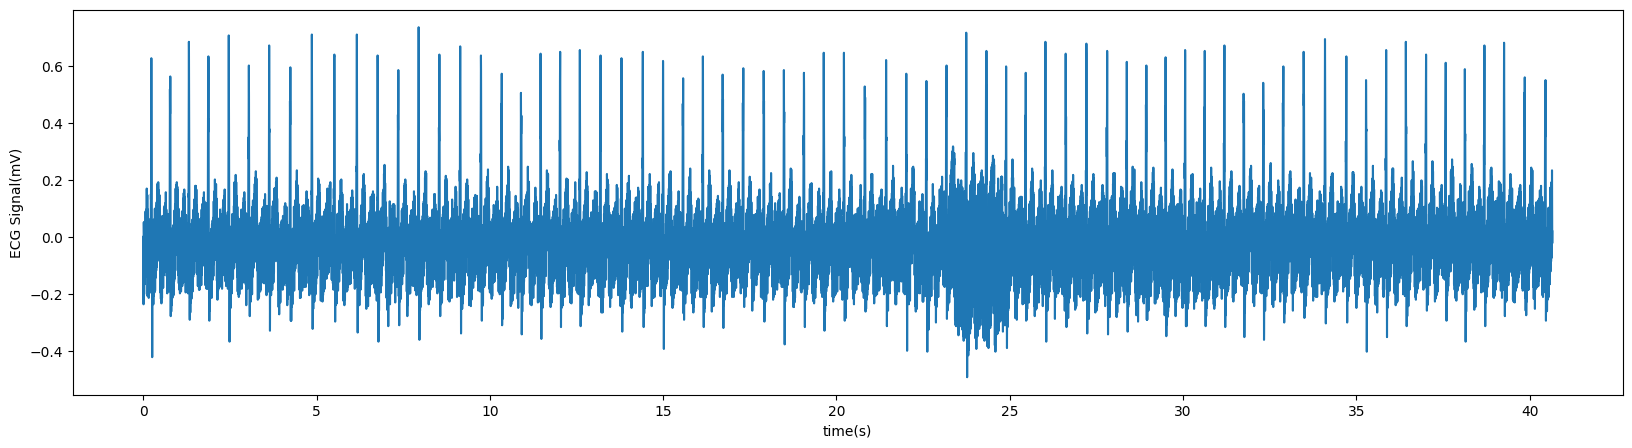

In [25]:
f = open("ecg2reposo.txt","r")
raw_data = f.read()
f.close()
Fs = 1000
Ts = 1/Fs
a = np.genfromtxt("./ecg2reposo.txt", delimiter="\t",skip_header = 3)
yarray = a[:, 5]
N=len(yarray)
bits = 10 # Bits de la salida
volt_range = 3.3
yarray = (yarray/2**bits -1/2) * volt_range/1009
yarray=yarray*1000 # convertir los bits a mV
voltaje = yarray - np.mean(yarray)
mtime = np.arange(1, len(yarray)+1)/Fs

plt.figure(figsize=(20,5))
plt.plot(mtime, voltaje)
plt.ylabel('ECG Signal(mV)')
plt.xlabel('time(s)')
plt.show()

**SE ANALIZA LA SEÑAL EN FRECUENCIA**

Conociendo los datos de adquisición de la señal, analicemos ahora el espectro de Fourier.

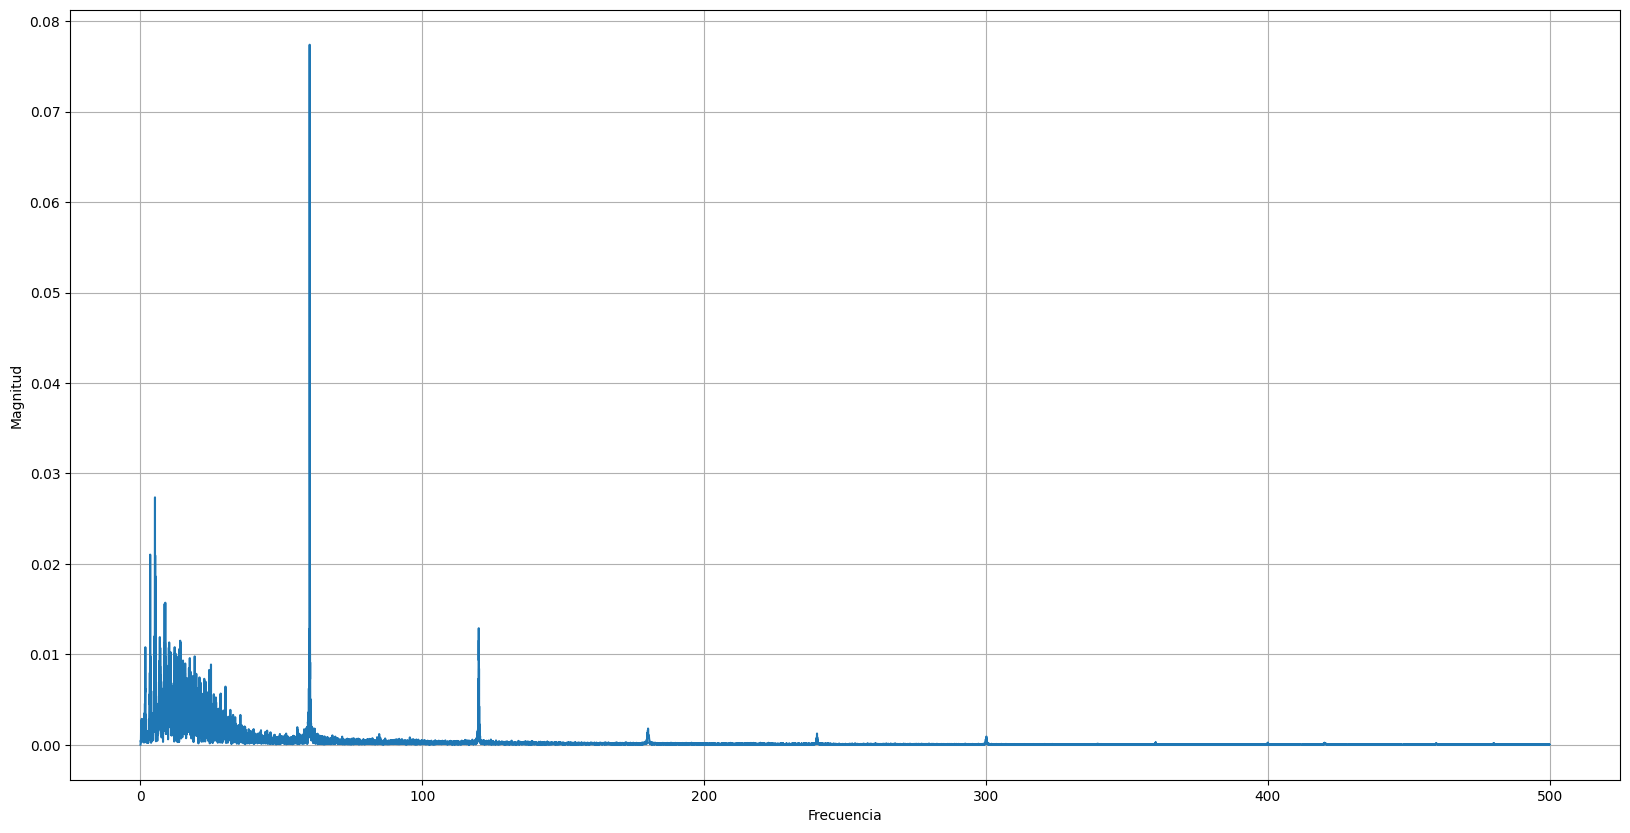

In [26]:
# Analizar el Fourier
ecg_senal = voltaje
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
T = Ts
N = len(ecg_senal)
yf = fft(ecg_senal)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()

En el gráfico anterior, existe un ruido en 50 Hz y armónicos en 150 HZ. Por lo tanto, se debe filtrar.

Se propone utilizar filtros digitales Notch



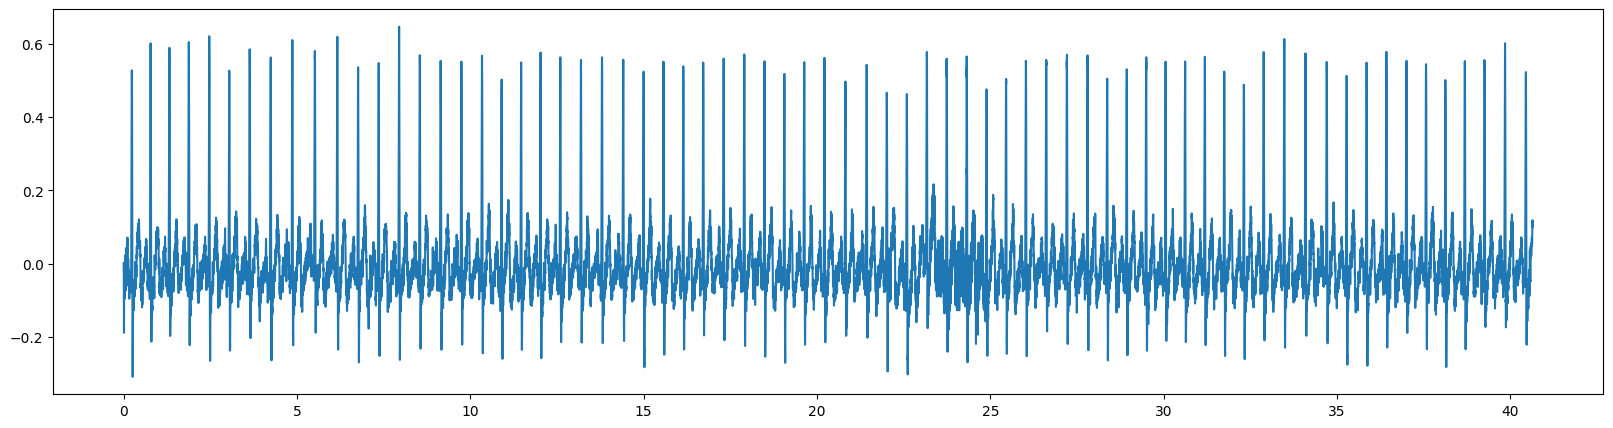

In [27]:
# Utilizar filtros Notch para quitar frecuencias que hagan ruido
from scipy.signal import iirnotch, lfilter
fs = 1/T  # Frecuencia de muestreo (Hz)
f0 = 50.0  # Frecuencia que queremos filtrar (Hz)
Q = 20.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b, a, ecg_senal)
y = lfilter(b, a, y)

fs = 1/T  # Frecuencia de muestreo (Hz)
f0 = 120.0  # Frecuencia que queremos filtrar (Hz)
Q = 7.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b,a,y)

fs = 1/T  # Frecuencia de muestreo (Hz)
f0 = 60.0  # Frecuencia que queremos filtrar (Hz)
Q = 7.0  # Factor de Calidad
# Diseño de filtro notch
b, a = iirnotch(f0, Q, fs)
y = lfilter(b,a,y)

plt.figure(figsize=(20,5))
#plt.xlim(0,200)
plt.plot(mtime,y)
plt.show()

Regresamos a verificar las atenuaciones de los filtros en frecuencia

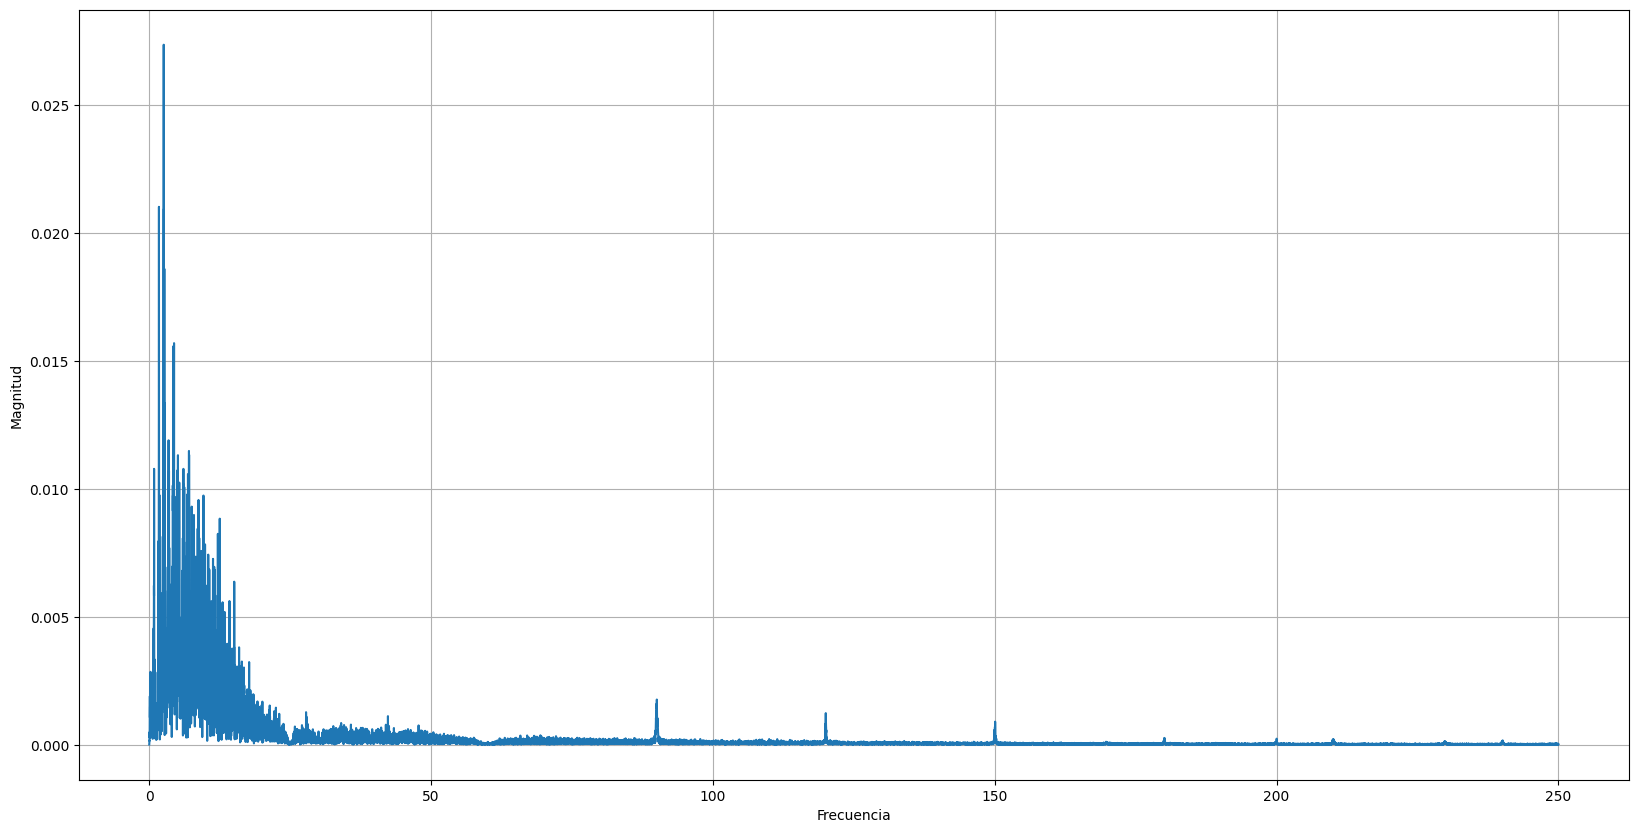

In [28]:
# Analisis de Fourier de los filtros
# Periodo de 2ms (0.002s) o frecuencia de 500 Hz
T = 0.002
N = len(y)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.show()
ecg_signal = y

**FILTRADO DE PASA BANDA**

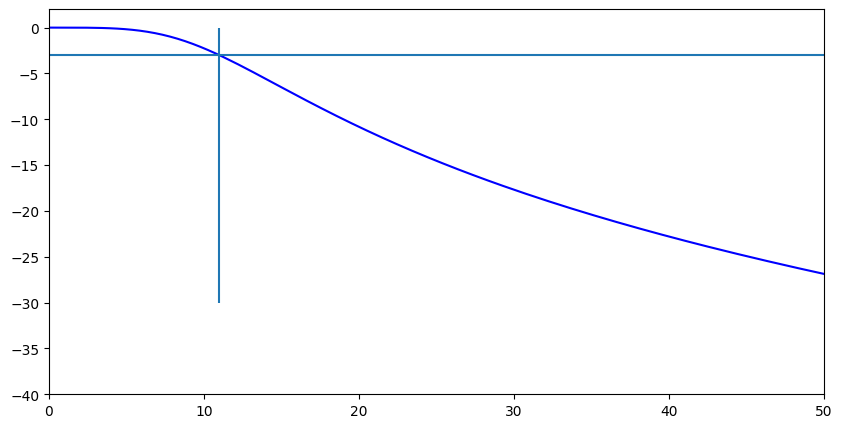

In [29]:
from scipy.signal import freqz, iirdesign, iirfilter, find_peaks
# 2. filtro pasa banda
# Sub filtro pasa bajo
b, a = iirfilter(2, 11.0, btype='lowpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(11, -30, 0)
plt.ylim(-40,2)
plt.show()

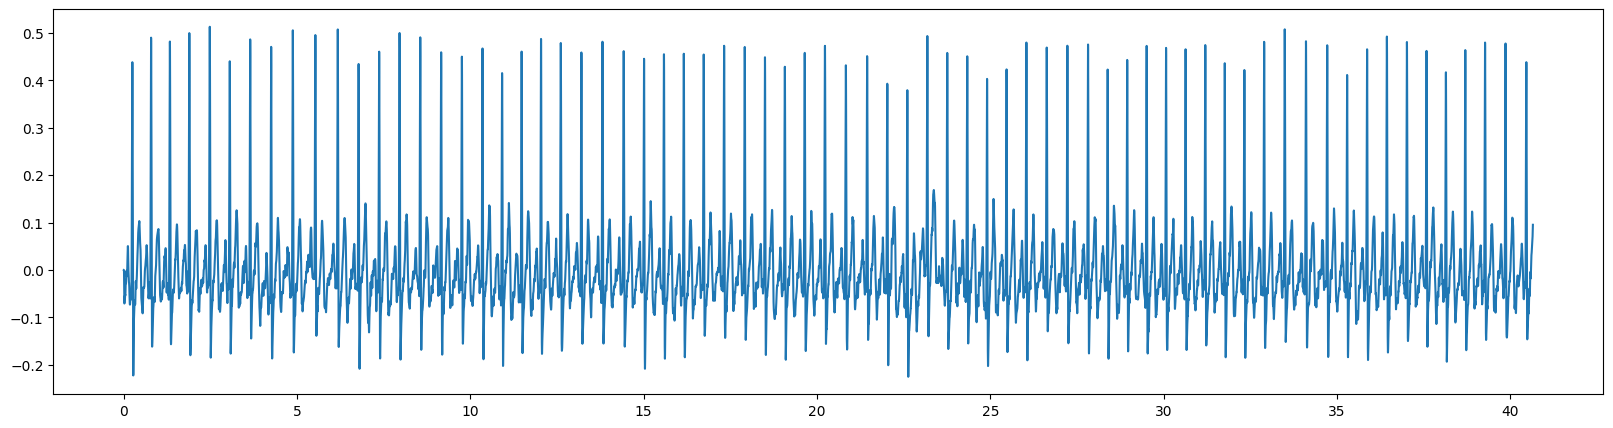

In [30]:
fpb_signal = lfilter(b, a, ecg_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime,fpb_signal)
plt.show()

**FILTRO PASA ALTO**

<ipython-input-31-80dbcbcf6ac0>:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


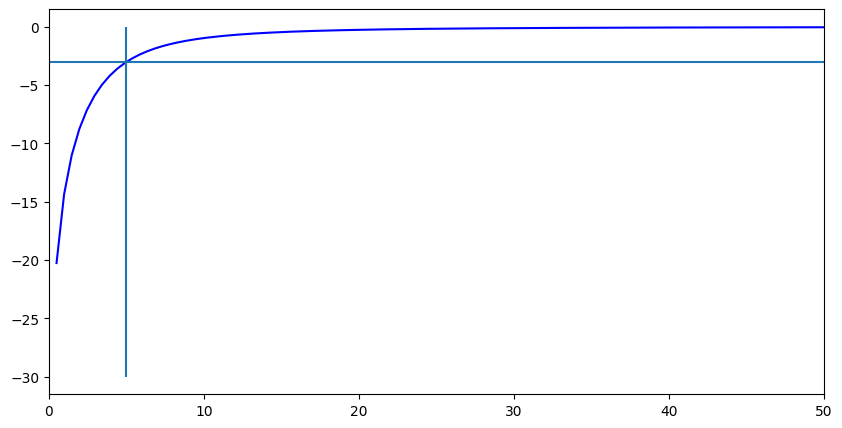

In [31]:
b, a = iirfilter(1, 5.0, btype='highpass', rs=3, ftype='butter', fs=500)
w, h = freqz(b, a, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.hlines(-3,0,250)
plt.xlim(0,50)
plt.vlines(5, -30, 0)
plt.show()


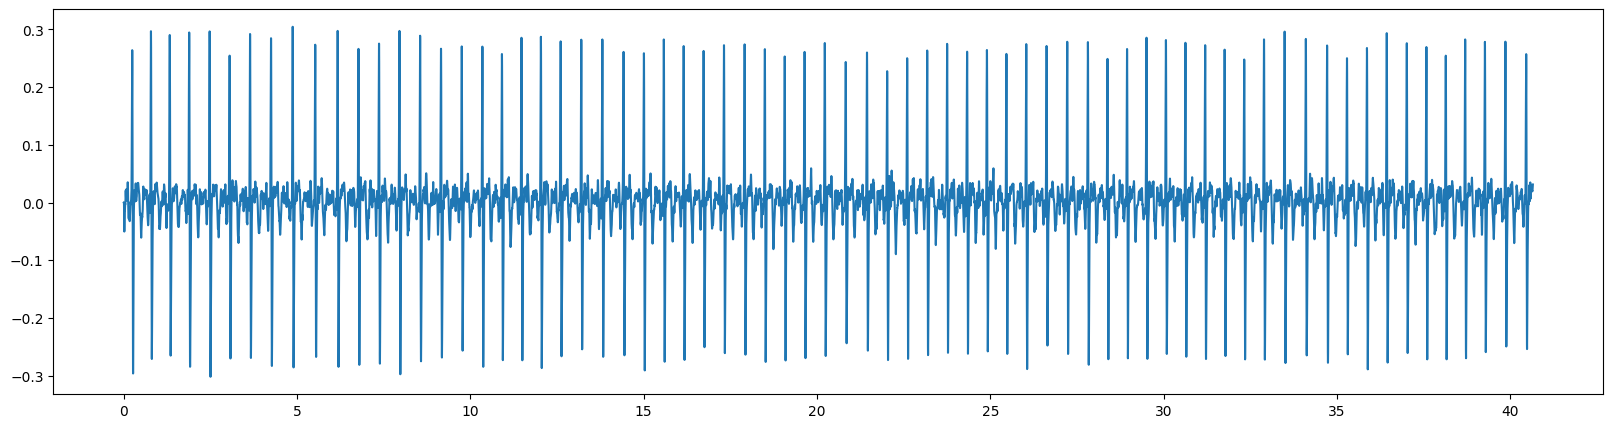

In [32]:
fpa_signal = lfilter(b, a, fpb_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime,fpa_signal)
plt.show()

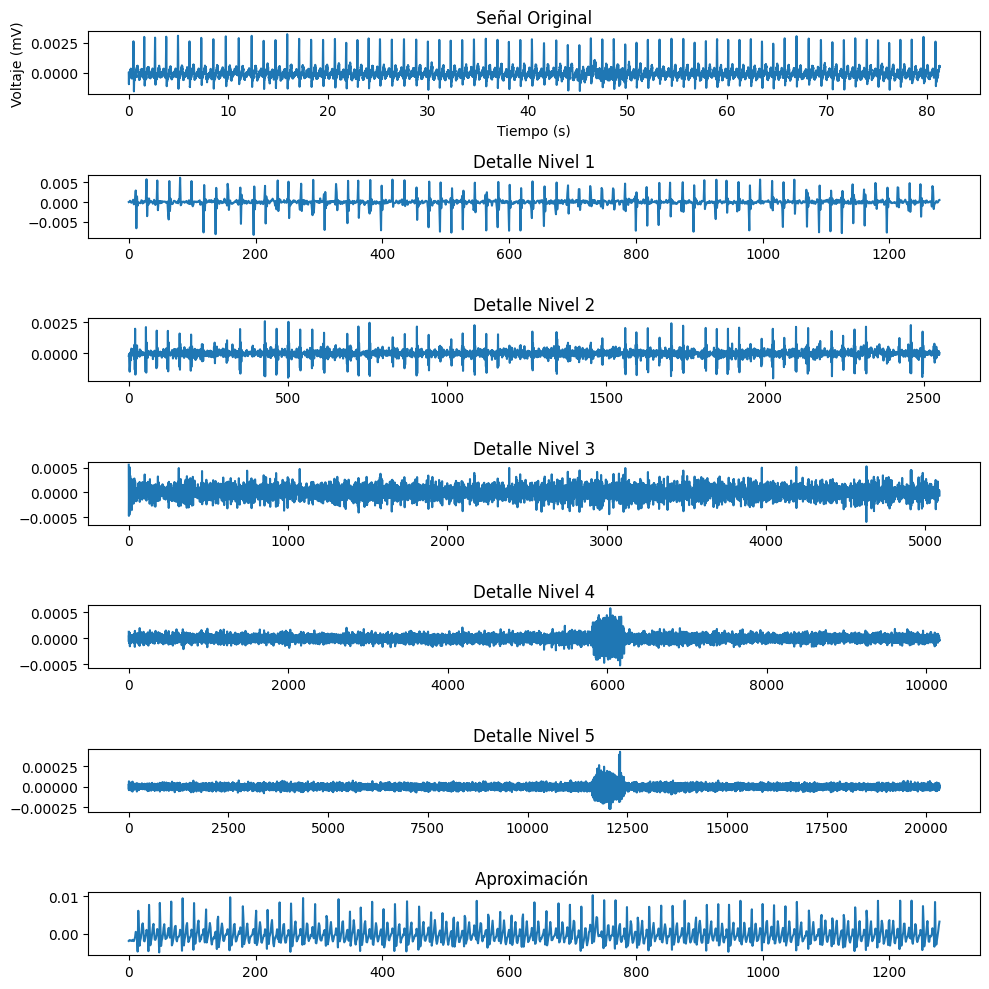

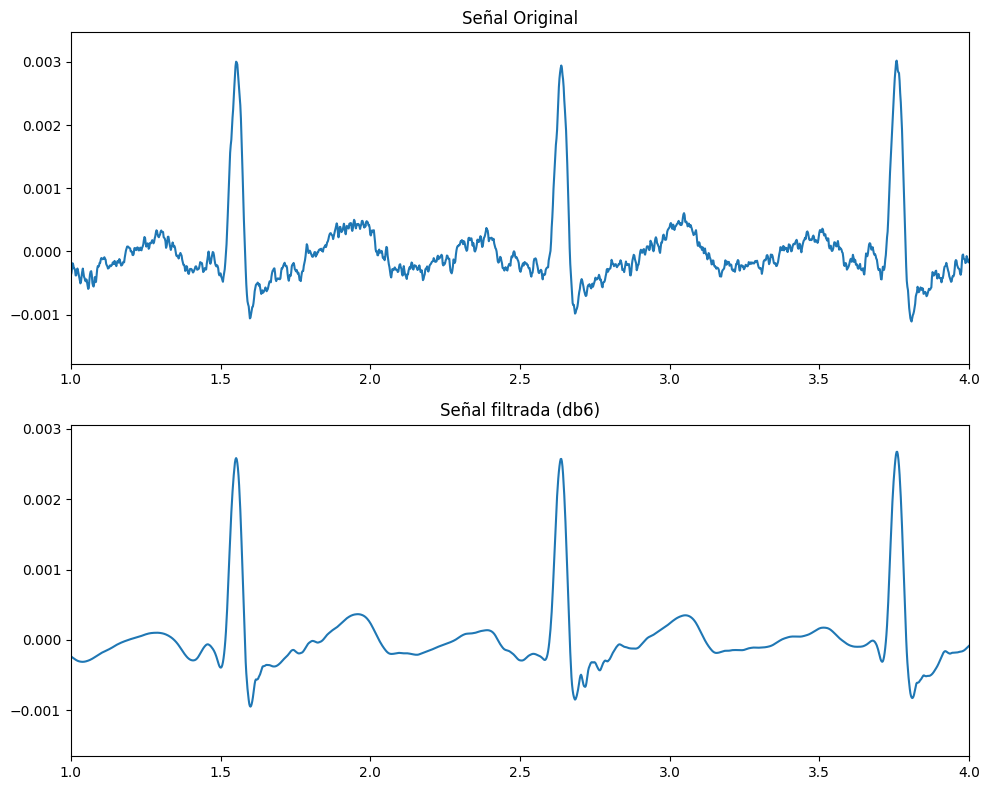

In [33]:
#######################
import numpy as np
import pywt

y = ecg_signal
y=y/200

Ts = T
t = np.arange(0, len(y)*Ts, Ts)

niveles = 5
coeficientes = pywt.wavedec(y, 'db6', level=niveles)

plt.figure(figsize=(10, 10))
plt.subplot(niveles + 2, 1, 1)
plt.plot(t,y)
plt.ylabel('Voltaje (mV)')
plt.xlabel('Tiempo (s)')
plt.title('Señal Original')
# Graficar los coeficientes de detalle
for i, detalle in enumerate(coeficientes[1:]):  # Empezar desde el segundo nivel
    plt.subplot(niveles + 2, 1, i + 2)
    plt.plot(detalle)
    plt.title(f'Detalle Nivel {i+1}')

# Graficar el coeficiente de aproximación
plt.subplot(niveles + 2, 1, niveles + 2)
plt.plot(coeficientes[0])
plt.title(f'Aproximación ')

plt.tight_layout()
plt.show()

umbral = 0.0005

coeficientes_umbral = [pywt.threshold(c, umbral, mode='soft') for c in coeficientes]

senal_denoised = pywt.waverec(coeficientes_umbral, 'db6')

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(t, y)
plt.xlim(1,4)
plt.title('Señal Original')

plt.subplot(2, 1, 2)
plt.plot(t, senal_denoised)
plt.xlim(1,4)
plt.title('Señal filtrada (db6)')

plt.tight_layout()
plt.show()

**OPERADOR DERIVATIVO**

En el artículo nos dan la siguiente función que describe al operador:

y[n]=(1/8)(−x[n−2]−2x[n−1]+2x[n+1]+x[n+2])

Para que esta ecuación pueda ser utilizada necesitamos encuadrarla en un rango de  [0,+∞]  haciendo que  n=+2  entonces tenemos:

y[n]=(1/8)(−x[n]−2x[n+1]+2x[n+3]+x[n+4])

Por lo tanto:

b=[−1,−2,0,2,1]

<ipython-input-34-22fad9ce2312>:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w, 20 * np.log10(abs(h)), 'b')


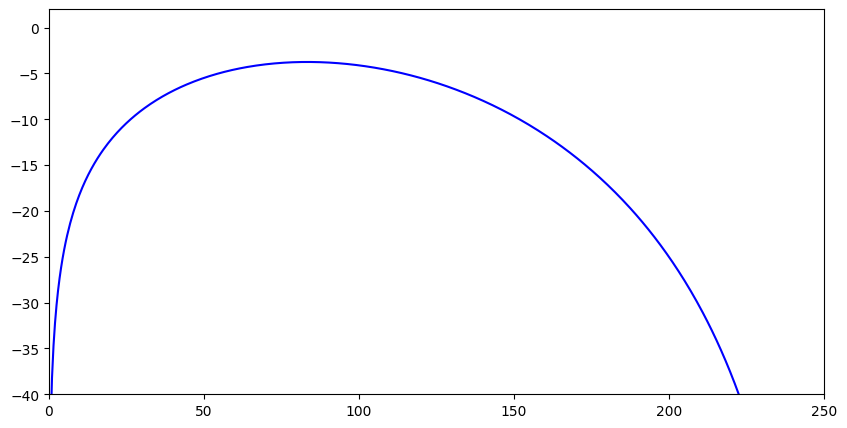

In [34]:
# Filtro derivativo
b = np.array([-1, -2, 0, 2, 1])
b = (1/8)*b
w, h = freqz(b, 1, fs=500)
plt.figure(figsize=(10,5))
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.xlim(0,250)
plt.ylim(-40,2)
plt.show()

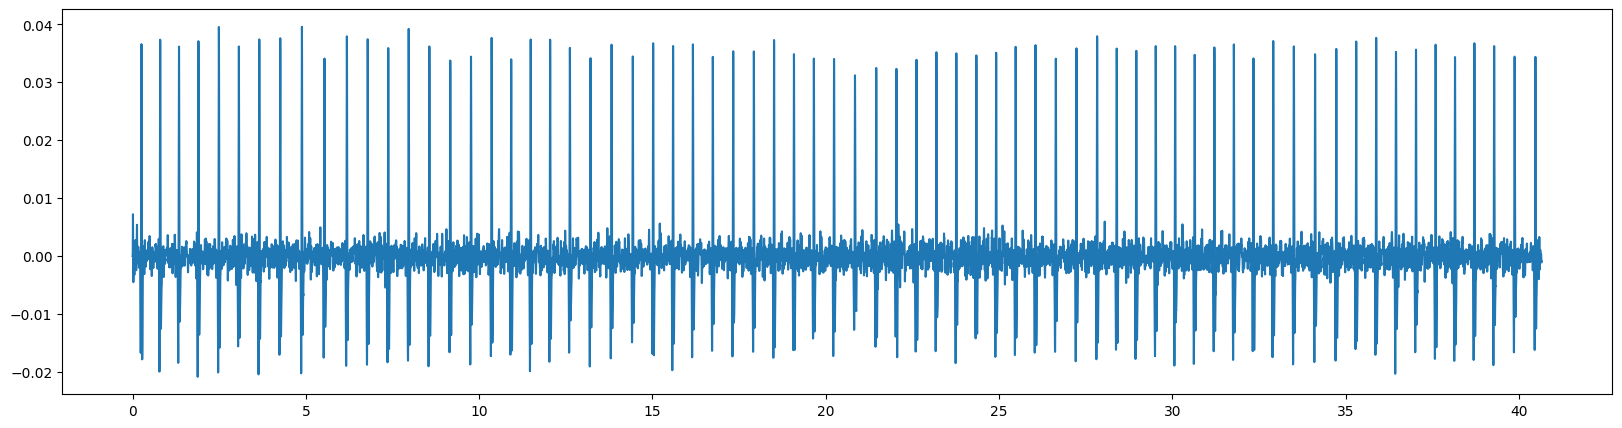

In [35]:
fd_signal = lfilter(b, 1, fpa_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime,fd_signal)
plt.show()

**OPERADOR CUADRÁTICO**

Este operador solo tiene como función elevar al cuadrado los valores de la señal.

y[n]=x^2[n]

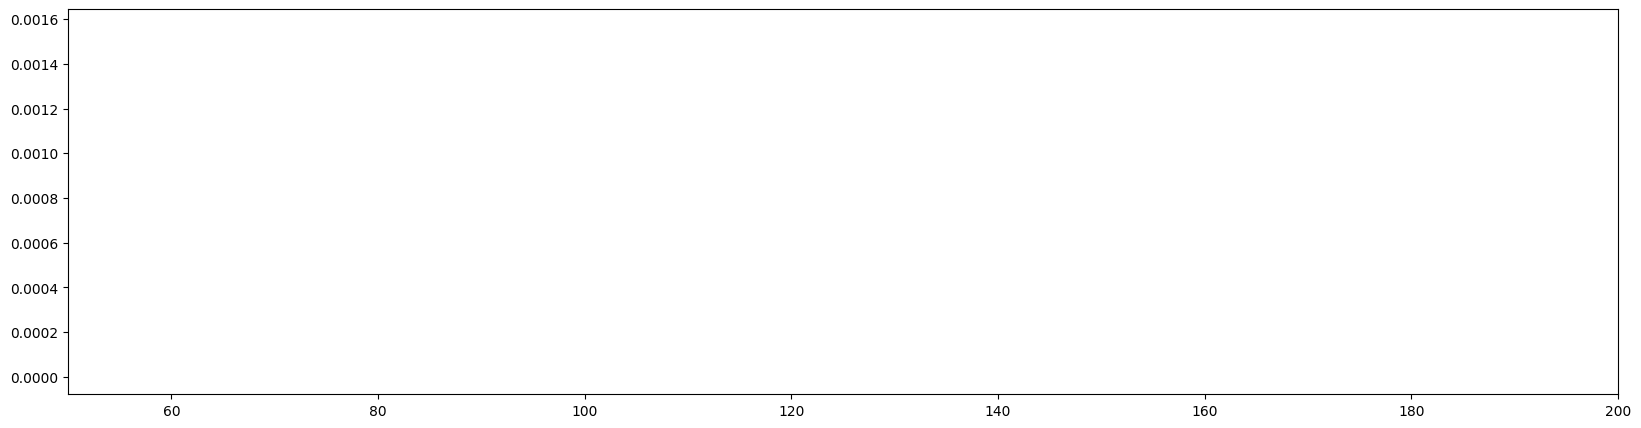

In [36]:
# Filtro cuadrado
f_sq = np.square(fd_signal)
plt.figure(figsize=(20,5))
plt.plot(mtime, f_sq)
plt.xlim(50,200)
plt.show()

**OPERADOR MOVING WINDOW INTEGRATION**

Este operador tiene como función extraer ciertas características de la onda.

y[n]=(1/N)(x[n−(N−1)]+x[n−(N−2)]+..+x[n])

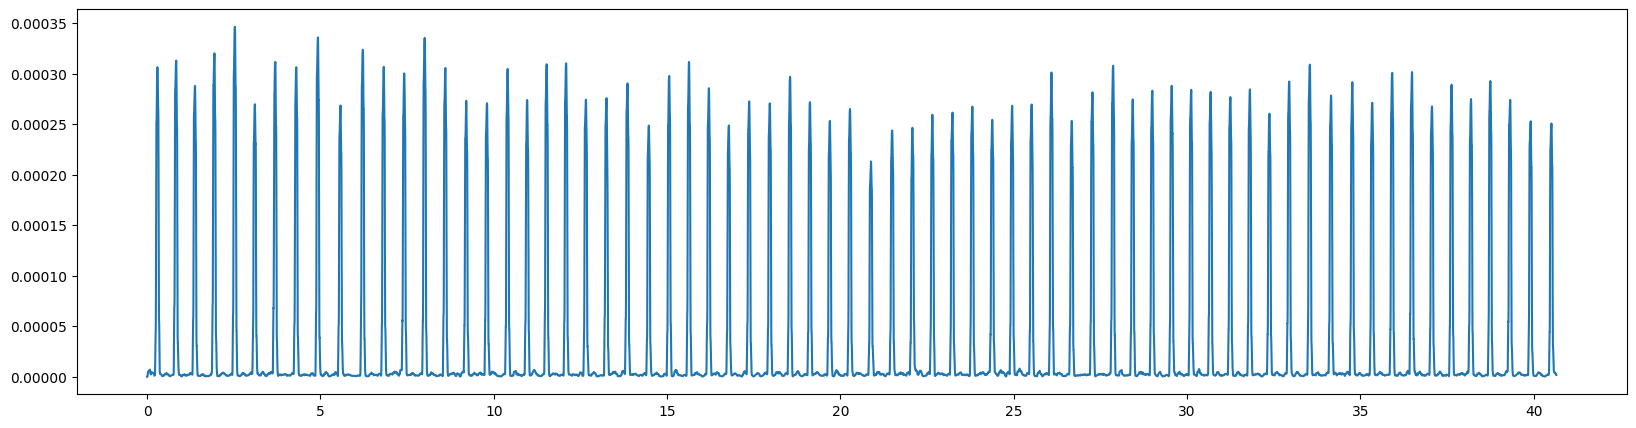

In [37]:
# Moving-Window Integration
N = 75
b = np.ones(N-1)
b = (1/N)*b
fi_signal = lfilter(b, 1, f_sq)
plt.figure(figsize=(20,5))
plt.plot(mtime,fi_signal)
plt.show()

Colocando marcadores en los picos

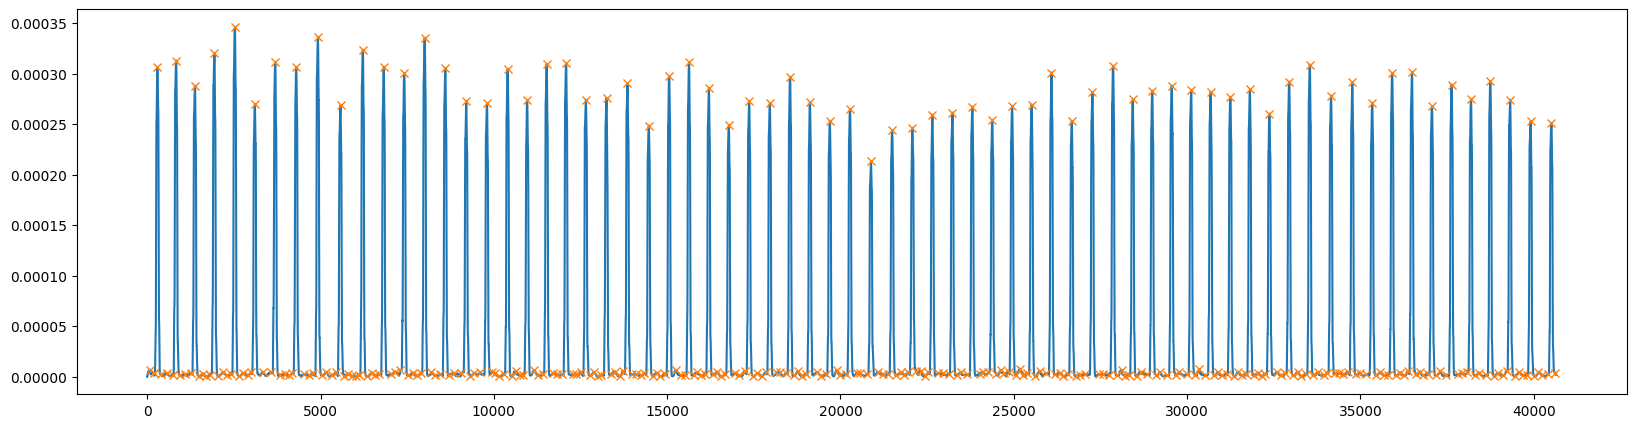

In [38]:
# Fiducial Marks
peaks, _ = find_peaks(fi_signal, distance=100)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
plt.plot(peaks, fi_signal[peaks], "x")
plt.show()

**ANÁLISIS DE THRESHOLD**

El valor del umbral de pico R de entrada es  8.663024314390692e-05
El valor del umbral de ruido de entrada es  3.259862244310244e-05


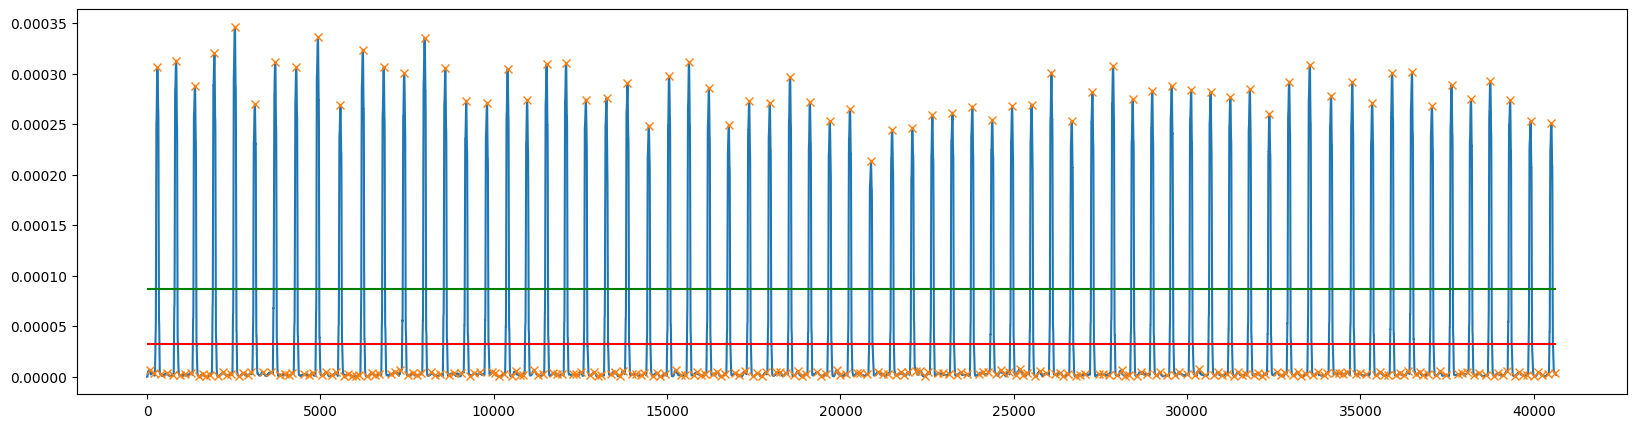

In [39]:
# Training Part to set Threshold I1 and Threshold I2
# Para las primeras muestras en 2 segundos
# Para efectos del ejercicio vamos a analizar toda la señal
f_samples = len(peaks)
th_I1 = np.max(fi_signal[peaks[:f_samples]])*0.25
th_I2 = 0.5*np.mean(fi_signal[peaks[:f_samples]])
print ("El valor del umbral de pico R de entrada es ", th_I1)
print ("El valor del umbral de ruido de entrada es ", th_I2)
plt.figure(figsize=(20,5))
plt.plot(fi_signal)
#plt.xlim(50,1000)
plt.plot(peaks, fi_signal[peaks], "x")
plt.hlines(th_I1, 0, len(fi_signal), colors='green')
plt.hlines(th_I2, 0, len(fi_signal), colors='red')
plt.show()

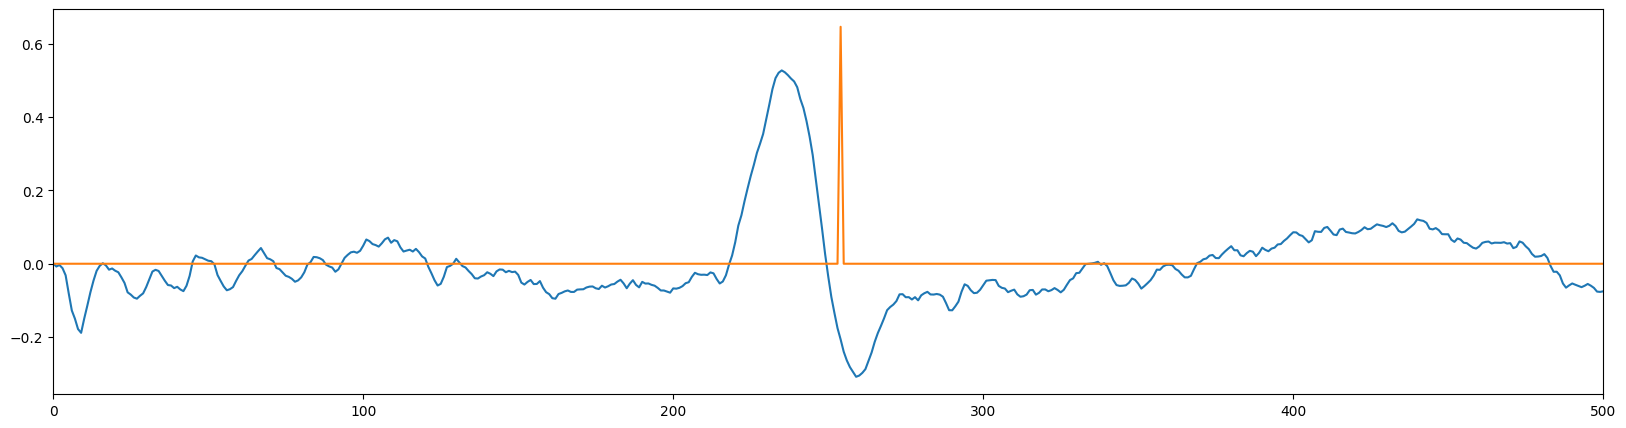

In [40]:
end_qrs = fi_signal > th_I1
roll_qrs_r = np.roll(end_qrs, 1)
roll_qrs_l = np.roll(end_qrs, -1)
end_qrs = np.logical_xor(end_qrs ,roll_qrs_r)
end_qrs = np.logical_and(end_qrs ,roll_qrs_l)
plt.figure(figsize=(20,5))
plt.xlim(0,500)
plt.plot(ecg_signal)
plt.plot(end_qrs*np.max(ecg_signal))
plt.show()

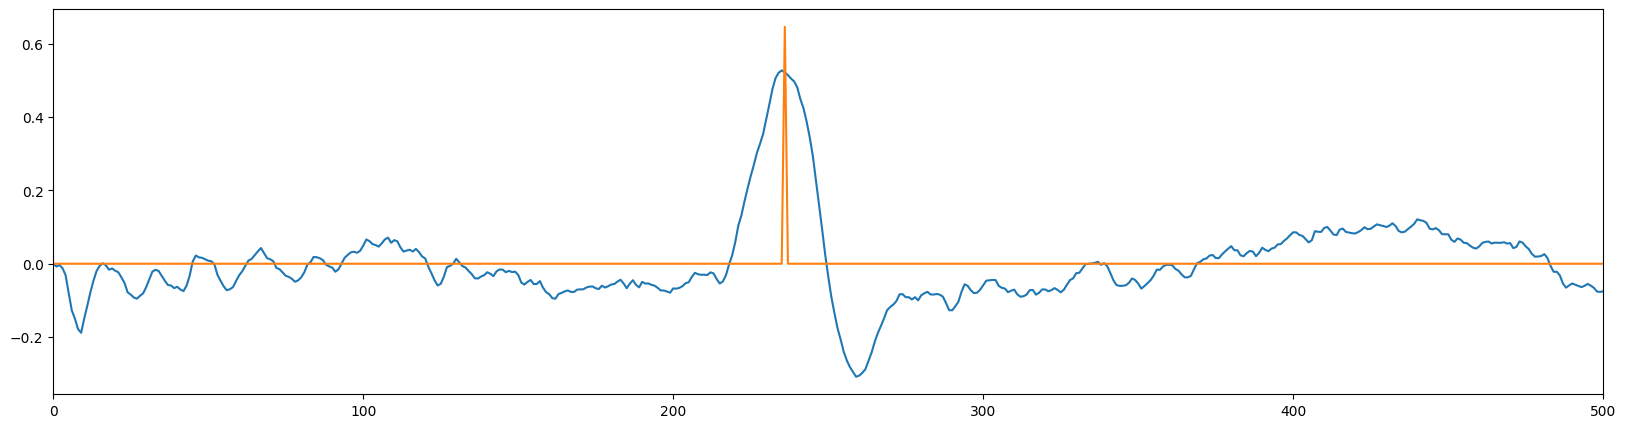

In [41]:
start_qrs = fi_signal < th_I2
roll_qrs_l = np.roll(start_qrs, -1)
roll_qrs_r = np.roll(start_qrs, 1)
start_qrs = np.logical_xor(start_qrs ,roll_qrs_l)
start_qrs = np.logical_and(start_qrs ,roll_qrs_r)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal)
plt.xlim(0,500)
plt.plot(start_qrs*np.max(ecg_signal))
plt.show()

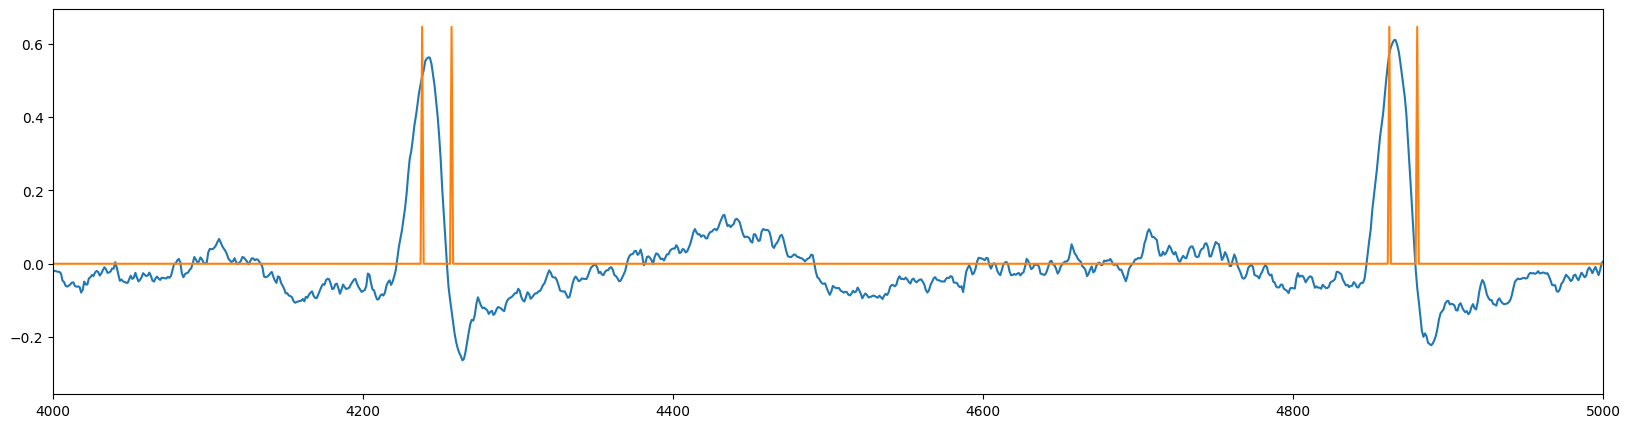

In [42]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.xlim(4000,5000)
plt.plot(ecg_signal)
plt.plot(qrs*np.max(ecg_signal))
plt.show()


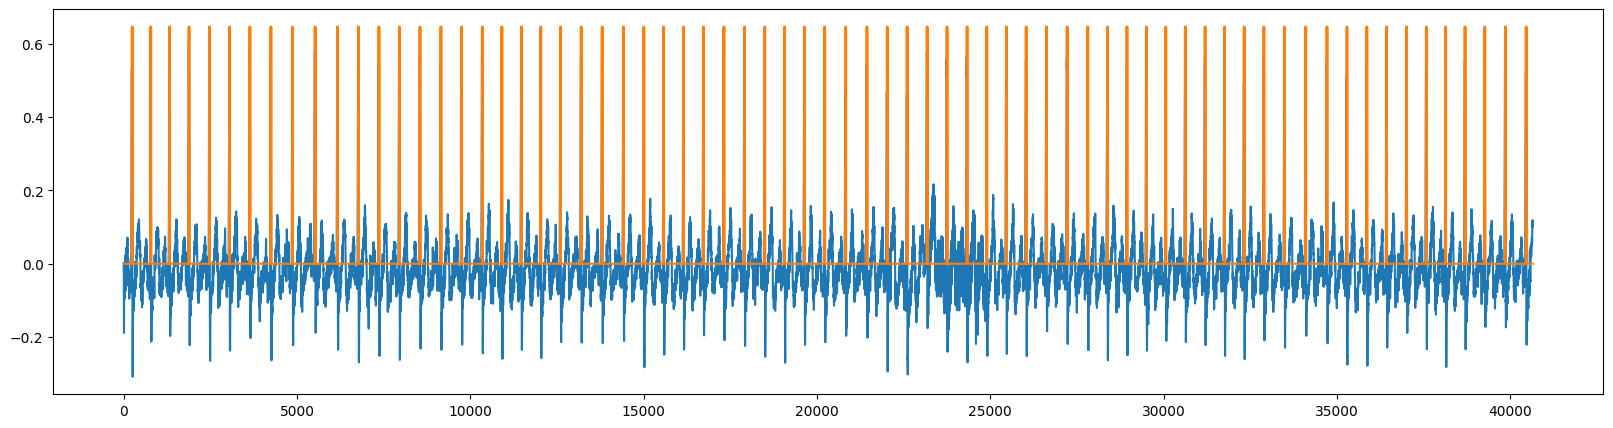

In [43]:
qrs = np.logical_or(start_qrs, end_qrs)
plt.figure(figsize=(20,5))
plt.plot(ecg_signal) #
plt.plot(qrs*np.max(ecg_signal))#
plt.show()

In [44]:
pip install neurokit2
import neurokit2 as nk


SyntaxError: ignored